Whale optimization algorithm is a meta heuristic algorithm similar to grey wolf optimization. However, instead of a complete hierarchy, there is only a leader present, alll other search agents update their positions based on the position of leader. There is a continuous switching between exploration and exploitation. 

Here the fitness function is borrowed from Grey wolf optimization. 

In [1]:
# importing required libraries 
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
# defining a suitable fitness function
n_rec = 51 # number of receivers
def fitness(pos_matrix,ToA,wave_vel):
    '''The function returns the error value for a given position matrix(pos_matrix) consisting of source location as the first element
    and the receiver positions as all the rest elements. ToA is a vector of the time of arrival of seismic waves for receivers
    Wave_vel is the velocity of waves'''
    
    n_rec = np.shape(ToA)[0]
    TDoA = np.zeros(shape= (n_rec-1)) # created a new variable which will store time difference wrt the first receiver
    TDoA[:] = (ToA[1:] - ToA[0]).reshape(n_rec-1)
    # Now getting the value for time of arrival from the position of source and receivers
    ToA_pos = np.zeros_like(ToA)
    pos_diff = np.zeros(shape = (np.shape(pos_matrix)[0]))  # vector denoting the position of receivers wrt source
    pos_diff = pos_matrix[1:] - pos_matrix[0]
    ToA_pos[:] = (np.sqrt(pos_diff[1::2]**2 + \
                          pos_diff[1::2]**2)).reshape(n_rec,1)/wave_vel
    TDoA_pos = np.zeros_like(TDoA)
    TDoA_pos[:] = (ToA_pos[1:] - ToA_pos[0]).reshape(n_rec-1)
    error_vector = TDoA_pos - TDoA
    error = np.dot(error_vector.T,error_vector)
    
    return error

In [3]:
# Now generating the synthetic data for testing
wave_vel = 1 # m/s

rec_pos_actual =300 + np.random.normal(loc=0.0,scale =50,size = (n_rec,2))  # actual position for 2 receivers
src_pos_actual = np.array([0,0])
t_rec_ideal = np.zeros(shape =(n_rec,1))
# calculating the ideal time of arrival
t_rec_ideal[0:n_rec] = np.sqrt((rec_pos_actual[0:n_rec,1]-src_pos_actual[1])**2 + (rec_pos_actual[0:n_rec,0]-src_pos_actual[0])**2).reshape(n_rec,1)
#introducing noise to account for error in onset detection and sensor
noise_t = np.random.normal(loc=0.0,scale =0.2,size = (n_rec,1))
t_Rec_real = np.array(t_rec_ideal + noise_t)

In [4]:
# Now generating some random solutions for input and intializing number of wolves and their types, alpha, beta and delta are taken to be one each 

n_whales = 15 # number of wolves 
initial_pos = 300  + np.random.normal(loc=0.0,scale =50,size = (n_whales,(n_rec+1)*2))  # in order to make sure that the spread is in entire domain

In [5]:
n_iter = 50000 # number of iterations

In [6]:
def Whale_optimization(n_iter,n_whales,initial_pos,t_Rec_real):
    '''The function returns the optimzed location for leader in the search space according to Whale Optimization algorithm.
    n_iter = number of iterations
    n_whales = number of whales
    initial_pos = initial position of all whales'''
    
    TOA_min = np.min(t_Rec_real)
    TOA_max = np.max(t_Rec_real)
    TOA_avg = np.mean(t_Rec_real)
    whales_pos = np.copy(initial_pos)
    fitness_array =np.zeros(n_iter)
    
    fitness_value = np.zeros(n_whales)
    
    # Assigning the position and fitness for leader
    
    leader_fitness = fitness_value[0]
    leader_pos = np.copy(whales_pos[0]) 
    
    for i in range(n_iter):
        fitness_array[i] = leader_fitness
        for j in range(n_whales):
            fitness_value[j] = fitness(whales_pos[j],t_Rec_real,wave_vel = wave_vel)
            if fitness_value[j] <= leader_fitness:
                leader_fitness = fitness_value
                leader_pos = np.copy(whales_pos[j]) 
        # Now updating the position
        
        # Defining parameters for updating positions
        a =  2 - i*2/n_iter
        a2 = -1 + i*(-1/n_iter)
        for j in range(n_whales):
            r1 = np.random.random(size=(np.shape(leader_pos)))
            r2 = np.random.random(size=(np.shape(leader_pos)))
            A = 2*a*r1 - a
            C =2*r2
            b = 1
            l = (a2-1)*np.random.random() + 1
            p = np.random.random()
            
            if p < 0.5:
                for k in range(np.size(leader_pos)):
                    if abs(A[k]) > 1:
                        temp_leader = np.random.randint(low=0,high=n_whales,size=1)
                        temp_leader_pos = whales_pos[temp_leader,k]
                        D_leader_temp = abs(C*temp_leader_pos- whales_pos[j,k])  
                        whales_pos[j,k] = leader_pos[k] - A[k] * whales_pos[j,k]
                    elif abs(A[k]) < 1:
                        D_leader = abs(C*leader_pos[k] - whales_pos[j,k])  
                        whales_pos[j,k] = leader_pos[k] - A[k] * whales_pos[j,k]
                        
                        
            
            elif p > 0.5:
                for k in range(np.size(leader_pos)):
                    Dist_leader = abs(leader_pos[k] - whales_pos[j,k])
                    whales_pos[j,k] = Dist_leader*np.exp(b*k)*np.cos(2*np.pi*l) + whales_pos[j,k]
                
                
                    if whales_pos[j,k] > 350 or whales_pos[j,k] <250 :# currently specific, will need to generalize
                        whales_pos[j,k] = 250 + 100*np.random.random()
                
                
    return leader_pos,fitness_array
        

In [7]:
optimized_pos, fitness_array = Whale_optimization(n_iter=n_iter,n_whales =n_whales,initial_pos = initial_pos,t_Rec_real=t_Rec_real)

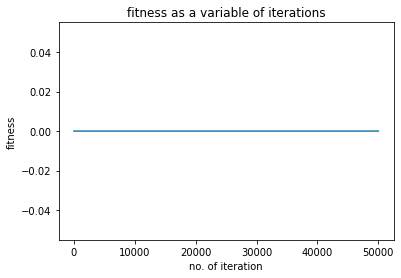

In [8]:
import matplotlib.pyplot as plt
index_of_iteration= list( range(0,n_iter))
plt.plot(index_of_iteration,fitness_array)
plt.xlabel("no. of iteration")
plt.ylabel("fitness")
plt.title("fitness as a variable of iterations")
plt.show()
